In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import parselmouth
import random
import librosa

In [2]:

# ! Load Data Block

# loading the data from the data directory
df = pd.read_csv('Dataset\\truncated_train.csv')
df

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
14996,cv-valid-train/sample-014996.mp3,we speak of them only to children,4,0,NaN,NaN,NaN,NaN
14997,cv-valid-train/sample-014997.mp3,its been a long time since she last read chekh...,1,0,NaN,NaN,NaN,NaN
14998,cv-valid-train/sample-014998.mp3,for at that time it had not occurred to him th...,1,0,fourties,male,newzealand,NaN
14999,cv-valid-train/sample-014999.mp3,yeah better if people are already familiar wit...,1,0,NaN,NaN,NaN,NaN


In [3]:

# ! Extract Features Block

# * Calculate the Root Mean Square Energy
def calculate_rmse(y):
    return np.sqrt(np.mean(y**2))

# * Extract formant frequencies from an audio file
def extract_formants(sound, time_step=0.1, max_formants=3, max_formant_freq=4000):

    # * Create a Formant object with parameters for time step and maximum formant frequency
    formant = sound.to_formant_burg(time_step=time_step, max_number_of_formants=max_formants, maximum_formant=max_formant_freq)

    formant_frequencies = []
    # * Loop through the sound's duration to extract formant frequencies
    times = np.arange(0, sound.duration, time_step)

    for t in times:
        formant_freqs = [formant.get_value_at_time(i, t) for i in range(1, max_formants + 1)]
        formant_frequencies.append(formant_freqs)

    # * Compute the mean of each formant, ignoring NaN values
    formant_avg = np.nanmean(formant_frequencies, axis=0)

    return formant_avg[:3]  # * Return the first three formants (F1, F2, F3)

# * Extract features, including RMSE, pitch, spectral features, and formants
def extract_features(file_path):

    # * Load the audio file using librosa
    y, sr = librosa.load(file_path, sr=None)

    # * Load the audio file into parselmouth for formant extraction
    sound = parselmouth.Sound(file_path)

    # * Extract pitch
    pitches, _ = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[np.nonzero(pitches)]) # * Taking mean of all non-zero pitches

    # * Calculate intensity with root mean square
    intensity = calculate_rmse(y)

    # * Get the duration of the audio
    duration = librosa.get_duration(y=y, sr=sr)

    # * Extract spectral features. Taking mean as we cant process an entire array 
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()

    # * Extract first 3 formants of the audio
    formant_freqs = extract_formants(sound, time_step=0.1, max_formants=3, max_formant_freq=4000)

    # * Create a Dictionary with all the extracted features
    features = {
        'pitch': pitch,
        'intensity': intensity,
        'duration': duration,
        'spectral_centroid': spectral_centroid,
        'spectral_bandwidth': spectral_bandwidth,
        'spectral_rolloff': spectral_rolloff,
        'formant_1': formant_freqs[0],  
        'formant_2': formant_freqs[1],  
        'formant_3': formant_freqs[2],  
    }

    return features


In [ ]:

# ! Get Features of All Audio Block

audio_dir = './Dataset/truncated-train/'  # First part of the audio file name

# df_features = pd.DataFrame([extract_features(os.path.join(audio_dir, fname)) for fname in df['filename']])
# l = pd.DataFrame(extract_features('Dataset/truncated-train/cv-valid-train/sample-000001.mp3'))

# * Combine audio_dir with audio file number to create the entire audio directory and then extract features of each audio file
df_features = pd.DataFrame([extract_features(os.path.join(audio_dir, fname)) for fname in df['filename']]) 



In [ ]:
df_features.head()

In [ ]:
df_features.to_csv('audio_features5.csv') # save features in a csv file

In [4]:

# ! Load Features Block

# * Loading features as a DataFrame
df_features = pd.read_csv("audio_features5.csv", index_col=None)
df_features.drop(columns="Unnamed: 0", inplace=True)
df_features.head()

,pitch,intensity,duration,spectral_centroid,spectral_bandwidth,spectral_rolloff,formant_1,formant_2,formant_3
0,1454.1493,0.082077,4.104,2618.802219,2587.432497,5065.482955,1064.924107,2280.064618,3181.088460
1,1906.1079,0.002443,7.560,4188.843736,3650.185186,8192.381435,909.400176,2221.297425,3316.028784
2,1653.3539,0.055574,5.064,2949.006081,2747.344233,5715.394737,904.612696,2490.554165,3156.471108
3,1619.7971,0.011463,6.648,3006.539710,3030.720627,5968.674880,817.119706,2018.535144,3259.061610
4,1335.2368,0.450064,4.896,2587.451157,2688.735752,4912.500000,1060.246694,2315.057935,3116.487521


In [5]:

# ! Creating a User Defined train_test_split function for the splitting the dataset


def train_test_split1(X, y, test_size=0.2, random_state=None):

    # Ensure consistent results with a random seed (if provided)
    if random_state is not None:
        np.random.seed(random_state)
    
    # Get the total number of samples
    total_samples = X.shape[0]
    
    # Shuffle the indices, keeping in mind, the seed being used
    indices = np.random.permutation(total_samples)
    
    # Determine the split index
    test_count = int(total_samples * test_size)
    train_count = total_samples - test_count
    
    # Split indices into training and testing
    train_indices = indices[:train_count]
    test_indices = indices[train_count:]
    
    # Create training and testing sets
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]
    
    return X_train, X_test, y_train, y_test


In [6]:

# ! Define Standard Scalers

class CustomStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None
    
    # * Fit the Dataset
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        return self
    
    # * Transform it by Scaling
    def transform(self, X):
        if self.mean_ is None or self.std_ is None:
            raise ValueError("Scaler has not been fitted.")
        return (X - self.mean_) / self.std_
    
    # * Fit new Dataset
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [7]:


# ! Dropping NULL rows

# * Convert age to numeric value for regression
age_dict = {'twenties': 25, 'thirties': 35, 'forties': 45, 'fifties': 55, 'sixties': 65, 'seventies': 75}
df['age_numeric'] = df['age'].map(age_dict)

# * Scale the features
custom_scaler = CustomStandardScaler()
scaled_features = custom_scaler.fit_transform(df_features)

# * Prepare the input features and target variable
X = pd.DataFrame(scaled_features, columns=df_features.columns)
y = df['age_numeric']

# * Dropping all NULL records from Attributes and Target labels Dataframes
X = X[y.notnull()]
y = y.dropna()

# * Split the data into training and testing sets (80% training, 20% testing)
# X_train, X_test, y_train, y_test = train_test_split1(X, y, test_size=0.2, random_state=42) # * have random state, same values
# X_train, X_test, y_train, y_test = train_test_split1(X, y, test_size=0.2) # * no random state, random values
X_train, y_train = X, y


In [8]:

# ! Run this to use specific attributes for training

X2 = X[['pitch', 'intensity', 'spectral_centroid', 'spectral_rolloff', 'formant_1', 'formant_2']] 
# X2 = X[['pitch', 'formant_1']]
# X2 = X[['pitch']]


# * Split the data into training and testing sets (80% training, 20% testing)
# X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42) # * have random state, same values
# X_train, X_test, y_train, y_test = train_test_split1(X2, y, test_size=0.2) # * no random state, random values
X_train, y_train = X2, y

In [9]:
X_train.head()

,pitch,intensity,spectral_centroid,spectral_rolloff,formant_1,formant_2
5,-0.924710,-1.094670,-0.627471,-0.357481,-1.478057,0.448956
8,0.351475,-0.873959,0.204577,-0.067348,0.151804,-0.540712
13,0.534931,-0.263771,-1.005001,-1.161983,0.098410,-0.066938
14,-2.020111,-0.413519,-0.657246,-0.559653,-1.009704,0.999661
19,-1.841977,-0.208928,-0.361969,-0.142174,0.203062,0.093361


In [10]:
y_train.head()

5     25.0
8     75.0
13    35.0
14    65.0
19    55.0
Name: age_numeric, dtype: float64

In [12]:

# ! Load Test Dataset

# loading the data from the data directory
df_test = pd.read_csv('Dataset\cv-valid-test.csv')
df_test



,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-test/sample-000000.mp3,without the dataset the article is useless,1,0,NaN,NaN,NaN,NaN
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,NaN
2,cv-valid-test/sample-000002.mp3,and you know it,1,0,NaN,NaN,NaN,NaN
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,NaN
4,cv-valid-test/sample-000004.mp3,hold your nose to keep the smell from disablin...,2,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3990,cv-valid-test/sample-003990.mp3,the old man opened his cape and the boy was st...,1,0,NaN,NaN,NaN,NaN
3991,cv-valid-test/sample-003991.mp3,in alchemy it's called the soul of the world,2,1,NaN,NaN,NaN,NaN
3992,cv-valid-test/sample-003992.mp3,at that point in their lives everything is cle...,3,0,NaN,NaN,NaN,NaN
3993,cv-valid-test/sample-003993.mp3,he told them all to be seated,3,0,NaN,NaN,NaN,NaN


In [ ]:

# ! Extract Test Features

audio_dir = './Dataset/cv-valid-test/'  # First part of the audio file name

# * Combine audio_dir with audio file number to create the entire audio directory and then extract features of each audio file
df_test_features = pd.DataFrame([extract_features(os.path.join(audio_dir, fname)) for fname in df_test['filename']]) 

df_test_features.to_csv('test_audio_features5.csv') # save features in a csv file



In [13]:

# ! Preprocess Test Dataset

# * Loading features as a DataFrame
df_test_features = pd.read_csv("test_audio_features5.csv", index_col=None)
df_test_features.drop(columns="Unnamed: 0", inplace=True)
df_test_features.head()


# * Convert age to numeric value for regression
age_dict = {'twenties': 25, 'thirties': 35, 'forties': 45, 'fifties': 55, 'sixties': 65, 'seventies': 75}
df_test['age_numeric'] = df_test['age'].map(age_dict)

# * Scale the features
custom_scaler = CustomStandardScaler()
scaled_features = custom_scaler.fit_transform(df_test_features)

# * Prepare the input features and target variable
X = pd.DataFrame(scaled_features, columns=df_test_features.columns)
y = df_test['age_numeric']

# * Dropping all NULL records from Attributes and Target labels Dataframes
X = X[y.notnull()]
y = y.dropna()

X2 = X[['pitch', 'intensity', 'spectral_centroid', 'spectral_rolloff', 'formant_1', 'formant_2']] 

# * Split the data into training and testing sets (80% training, 20% testing)
# X_train, X_test, y_train, y_test = train_test_split1(X, y, test_size=0.2, random_state=42) # * have random state, same values
# X_train, X_test, y_train, y_test = train_test_split1(X, y, test_size=0.2) # * no random state, random values
# X_test, y_test = X, y
X_test, y_test = X2, y

In [14]:
X_test.head()

,pitch,intensity,spectral_centroid,spectral_rolloff,formant_1,formant_2
1,0.630695,-0.048607,-0.374756,-0.279692,-0.407197,0.764355
3,-0.919192,-0.959038,-0.023436,0.224182,-0.738633,-0.785350
5,-0.880535,-0.000807,-0.754430,-0.747547,-0.454098,0.606457
6,1.473859,-1.049450,1.034194,1.064492,0.615846,0.967867
7,0.394809,-0.323986,0.618677,0.833970,0.090895,-0.206729


In [15]:
y_test.head()

1    25.0
3    25.0
5    25.0
6    25.0
7    35.0
Name: age_numeric, dtype: float64

In [16]:

# ! Define all User Defined Error Calcualting Functions

# * Custom function for Mean Squared Error
def mean_squared_error(y_true, y_pred):
    squared_differences = (y_pred - y_true) ** 2
    return np.mean(squared_differences) 

# * Custom function for Mean Absolute Error
def mean_absolute_error(y_true, y_pred):
    absolute_differences = np.abs(y_pred - y_true)
    mae = np.mean(absolute_differences)
    return mae

# * Custom function for R2 Score 
def r2_score(y_true, y_pred):
    y_mean = np.mean(y_true)  
    ss_tot = np.sum((y_true - y_mean) ** 2)  
    ss_res = np.sum((y_true - y_pred) ** 2)  
    r_squared = 1 - (ss_res / ss_tot)  
    return r_squared

In [17]:

# ! Train Linear Regression Model

# * Initialize weights and bias
n_features = X_train.shape[1]
weights = np.random.randn(n_features)
bias = random.random()  # Random bias

# * Hyperparameters
learning_rate = 0.1
epochs = 1000

# * Optimized function to calculate predictions
def predict(X, weights, bias):
    return np.dot(X, weights) + bias

 

# * Training loop with optimized computations
for epoch in range(epochs):
    
    # * Predictions
    predictions = predict(X_train, weights, bias)
    
    # * Calculate the loss (MSE)
    loss = mean_squared_error(y_train, predictions)
    loss /= 2
    
    # * Calculate gradients
    error = predictions - y_train  # * Vectorized error computation
    grad_weights = (np.dot(X_train.T, error)) / X_train.shape[0]  # * Vectorized gradient computation
    grad_bias = np.mean(error)  # * Bias gradient computed from error

    # grad_weights = None
    # for i in range(X_train.shape[0]):
        # f_w = np.dot(X_train.iloc[i], weights) + bias
        # grad_weights += (f_w - y_train.iloc[i]) * X_train.iloc[i]  
    
    # * Update weights and bias
    weights -= learning_rate * grad_weights
    bias -= learning_rate * grad_bias
    
    # * Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

# * Test predictions
test_predictions = predict(X_test, weights, bias)
test_loss = mean_squared_error(y_test, test_predictions)

print("Final Weights:", weights)
print("Final Bias:", bias)
print("Test Loss:", test_loss)

Epoch 0: Loss = 822.0233
Epoch 100: Loss = 110.6868
Epoch 200: Loss = 110.6222
Epoch 300: Loss = 110.5787
Epoch 400: Loss = 110.5493
Epoch 500: Loss = 110.5294
Epoch 600: Loss = 110.5159
Epoch 700: Loss = 110.5068
Epoch 800: Loss = 110.5007
Epoch 900: Loss = 110.4965
Final Weights: [ 1.9297207  -0.41200927 -2.17722531  2.42911012 -0.10059052 -0.89075277]
Final Bias: 38.00242476374015
Test Loss: 212.6342670392939


In [18]:

# ! Calculating Error

# * Test predictions 
test_predictions = predict(X_test, weights, bias)

# * Calculate evaluation metrics
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)
print("Root Mean Squared Error (RMSE):", np.sqrt(mse))


Mean Squared Error (MSE): 212.6342670392939
Mean Absolute Error (MAE): 12.094898405620766
R-squared (R²): 0.012458710169265474
Root Mean Squared Error (RMSE): 14.581984331334809


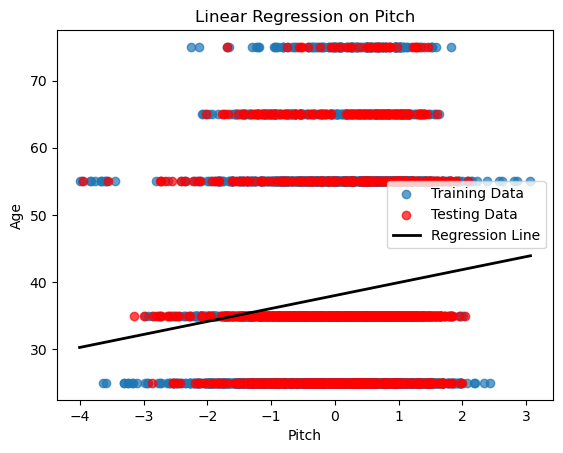

In [19]:

# ! Display Graph

# * Choose a specific feature to visualize
feature_name = 'pitch'

# * Scatter plot for training data
plt.scatter(X_train[feature_name], y_train, alpha=0.7, label='Training Data')
# * Scatter plot for testing data
plt.scatter(X_test[feature_name], y_test, color='red', alpha=0.7, label='Testing Data')

# * Calculate linear regression line for visualization
feature_range = np.linspace(X_train[feature_name].min(), X_train[feature_name].max(), 100)
# * Predict over a range of feature values
predictions = predict(feature_range.reshape(-1, 1), weights[0], bias)

# * Plot the linear regression line
plt.plot(feature_range, predictions, 'k', linewidth=2, label='Regression Line')

plt.xlabel(feature_name.capitalize())
plt.ylabel("Age")
plt.title(f"Linear Regression on {feature_name.capitalize()}")
plt.legend()
plt.show()
